In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [3]:
!pip install gdown


In [4]:
import tensorflow.compat.v1 as tf
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import DataLoader
import gdown
import numpy as np
import time
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [5]:
import h5py
import functools
import json
from torch_geometric.data import Data
import enum

import warnings
warnings.filterwarnings('ignore')

In [8]:
# change the foldername in your Drive where you have upload the Github repo
# make sure the route is corrent, e.g. My Drive or MyDrive
FOLDERNAME = 'MyDrive/MeshPhysicsGNN-NeuralOps-main'
assert FOLDERNAME is not None, "[!] Enter the foldername."

In [11]:
root_dir = "/content/drive/"+FOLDERNAME+"/main/"
checkpoint_dir=os.path.join(root_dir, 'best_model')

isExist = os.path.exists(checkpoint_dir)
if not isExist:
   os.makedirs(checkpoint_dir)

In [12]:
def triangles_to_edges(faces):
  """Computes mesh edges from triangles.
     Note that this triangles_to_edges method was provided as part of the
     code release for the MeshGraphNets paper by DeepMind, available here:
     https://github.com/deepmind/deepmind-research/tree/master/meshgraphnets
  """
  # collect edges from triangles
  edges = tf.concat([faces[:, 0:2],
                     faces[:, 1:3],
                     tf.stack([faces[:, 2], faces[:, 0]], axis=1)], axis=0)
  # those edges are sometimes duplicated (within the mesh) and sometimes
  # single (at the mesh boundary).
  # sort & pack edges as single tf.int64
  receivers = tf.reduce_min(edges, axis=1)
  senders = tf.reduce_max(edges, axis=1)
  packed_edges = tf.bitcast(tf.stack([senders, receivers], axis=1), tf.int64)
  # remove duplicates and unpack
  unique_edges = tf.bitcast(tf.unique(packed_edges)[0], tf.int32)
  senders, receivers = tf.unstack(unique_edges, axis=1)
  # create two-way connectivity
  return (tf.concat([senders, receivers], axis=0),
          tf.concat([receivers, senders], axis=0))

from pandas._libs import internals

# make sure the nodeType setting is the same as in the data processing notebook
class NodeType(enum.IntEnum):

    internal = 0
    perimeter = 1
    SIZE = 2

In [ ]:
# change the download route accordingly
%cd $root_dir
!gdown 1dGTZXI6xzqZZToLS173g3vYfNdl9oJ3o

/content/drive/MyDrive/MeshPhysicsGNN-NeuralOps
Downloading...
From: https://drive.google.com/uc?id=1dGTZXI6xzqZZToLS173g3vYfNdl9oJ3o
To: /content/drive/MyDrive/MeshPhysicsGNN-NeuralOps/3D_data_full_example.pt
100% 838M/838M [00:06<00:00, 139MB/s]


In [ ]:
dataset_full_timesteps = torch.load(root_dir+"3D_data_full_example.pt")

data_list = []

dataset1 = dataset_full_timesteps[:1]
print(dataset1)

[Data(x=[2997, 5], edge_index=[2, 33526], edge_attr=[33526, 4], x_without_features=[2997, 5], stress=[2997, 6], cells=[47096, 3], cells2=[282576, 3], mesh_pos=[2997, 3], stress11=[2997, 1], stress22=[2997, 1], stress33=[2997, 1], stress12=[2997, 1], stress13=[2997, 1], stress23=[2997, 1], stress_mises=[2997, 1], name='ro_0.230_ri_0.186_w_0.139_sw_0.024_n_3_E_10000000000.0_l_10000.0_rot_0.0')]


In [ ]:
def normalize(to_normalize,mean_vec,std_vec):
    return (to_normalize-mean_vec)/std_vec

def unnormalize(to_unnormalize,mean_vec,std_vec):
    return to_unnormalize*std_vec+mean_vec

def get_stats(data_list):
    '''
    Method for normalizing processed datasets. Given  the processed data_list,
    calculates the mean and standard deviation for the node features, edge features,
    and node outputs, and normalizes these using the calculated statistics.
    '''

    #mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    #mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    #mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].stress.shape[1:])
    std_vec_y=torch.zeros(data_list[0].stress.shape[1:])

    #Define the maximum number of accumulations to perform such that we do
    #not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to
    eps=torch.tensor(1e-8)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge=0
    num_accs_y=0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        #Add to the
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        mean_vec_edge+=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge+=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge+=dp.edge_attr.shape[0]

        mean_vec_y+=torch.sum(dp.stress,dim=0)
        std_vec_y+=torch.sum(dp.stress**2,dim=0)
        num_accs_y+=dp.stress.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y]

    return mean_std_list

In [ ]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()
        """
        MeshGraphNet model. This model is built upon Deepmind's 2021 paper.
        This model consists of three parts: (1) Preprocessing: encoder (2) Processor
        (3) postproccessing: decoder. Encoder has an edge and node decoders respectively.
        Processor has two processors for edge and node respectively. Note that edge attributes have to be
        updated first. Decoder is only for nodes.

        Input_dim: dynamic variables + node_type + node_position
        Hidden_dim: 128 in deepmind's paper
        Output_dim: dynamic variables: velocity changes (1)

        """

        self.num_layers = args.num_layers

        # encoder convert raw inputs into latent embeddings
        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear( input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )


        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))


        # decoder: only for node embeddings
        self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )


    def build_processor_model(self):
        return ProcessorLayer


    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        #x, edge_index, edge_attr, pressure = data.x, data.edge_index, data.edge_attr, data.p
        x, edge_index, edge_attr= data.x, data.edge_index, data.edge_attr

        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the specified hidden dimension

        edge_attr = self.edge_encoder(edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest

        return self.decoder(x)

    def loss(self, pred, inputs,mean_vec_stress,std_vec_stress):
        #Define the node types that we calculate loss for

        #normal=torch.tensor(0)
        #outflow=torch.tensor(5)

        #Get the loss mask for the nodes of the types we calculate loss for
        loss_mask=torch.logical_or((torch.argmax(inputs.x[:,3:],dim=1)==torch.tensor(0)),
                                   (torch.argmax(inputs.x[:,3:],dim=1)==torch.tensor(1)))


        #Normalize labels with dataset statistics
        labels = normalize(inputs.stress,mean_vec_stress,std_vec_stress)

        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        loss=torch.sqrt(torch.mean(error[loss_mask]))

        return loss

In [ ]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]

        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

In [ ]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [ ]:
def train(dataset, device, stats_list, args):
    '''
    Performs a training loop on the dataset for MeshGraphNets. Also calls
    test and validation functions.
    '''

    df = pd.DataFrame(columns=['epoch','train_loss','test_loss', 'velo_val_loss'])

    #Define the model name for saving
    model_name='model_seeds'+str(seedss)+'_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)+time.strftime('%Y-%b-%d-%H-%M-%S')

    #torch_geometric DataLoaders are used for handling the data of lists of graphs
    loader = DataLoader(dataset[:args.train_size], batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(dataset[args.train_size:], batch_size=args.batch_size, shuffle=False)

    #The statistics of the data are decomposed
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

    # build model
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    num_classes = 6 # the stress variables have the shape of 1

    model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(device)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_losses = []
    velo_val_losses = []
    best_test_loss = np.inf
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops=0
        for batch in loader:
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            batch=batch.to(device)
            opt.zero_grad()         #zero gradients each time
            pred = model(batch,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss = model.loss(pred,batch,mean_vec_y,std_vec_y)
            loss.backward()         #backpropagate loss
            opt.step()
            total_loss += loss.item()
            num_loops+=1
        total_loss /= num_loops
        losses.append(total_loss)

        #Every tenth epoch, calculate acceleration test loss and velocity validation loss
        if epoch % 10 == 0:
            if (args.save_velo_val):
                # save velocity evaluation
                test_loss, velo_val_rmse = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)
                velo_val_losses.append(velo_val_rmse.item())
            else:
                test_loss, _ = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)

            test_losses.append(test_loss.item())

            # saving model
            if not os.path.isdir( args.checkpoint_dir ):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, model_name+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)

        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            if (args.save_velo_val):
              test_losses.append(test_losses[-1])
              velo_val_losses.append(velo_val_losses[-1])

        if (args.save_velo_val):
            df = df.append({'epoch': epoch,'train_loss': losses[-1],
                            'test_loss':test_losses[-1],
                           'velo_val_loss': velo_val_losses[-1]}, ignore_index=True)
        else:
            df = df.append({'epoch': epoch, 'train_loss': losses[-1], 'test_loss': test_losses[-1]}, ignore_index=True)
        if(epoch%100==0):
            if (args.save_velo_val):
                print("train loss", str(round(total_loss, 2)),
                      "test loss", str(round(test_loss.item(), 2)),
                      "velo loss", str(round(velo_val_rmse.item(), 5)))
            else:
                print("train loss", str(round(total_loss,2)), "test loss", str(round(test_loss.item(),2)))


            if(args.save_best_model):

                PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
                torch.save(best_model.state_dict(), PATH )

    return test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader

def test(loader,device,test_model,
         mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y, is_validation,
          delta_t=0.01, save_model_preds=False, model_type=None):

    '''
    Calculates test set losses and validation set errors.
    '''

    loss=0
    velo_rmse = 0
    num_loops=0

    for data in loader:
        data=data.to(device)
        with torch.no_grad():

            #calculate the loss for the model given the test set
            pred = test_model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss += test_model.loss(pred, data,mean_vec_y,std_vec_y)

        num_loops+=1
        # if velocity is evaluated, return velo_rmse as 0
    return loss/num_loops, velo_rmse/num_loops

In [ ]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

seedss=5

for args in [
        {'model_type': 'meshgraphnet',
         'num_layers': 20,
         'batch_size': 4,
         'hidden_dim': 32,
         'epochs': 3100,
         'seeds':seedss,
         'opt': 'adam',
         'opt_scheduler': 'none',
         'opt_restart': 0,
         'weight_decay': 5e-4,
         'lr': 0.001,
         'train_size': 160,
         'test_size': 40,
         'device':'cuda',
         'shuffle': True,
         'save_velo_val': False,
         'save_best_model': True,
         'checkpoint_dir': root_dir+"best_model/",
         },
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html

torch.manual_seed(seedss)  #Torch
random.seed(seedss)        #Python
np.random.seed(seedss)     #NumPy

In [ ]:
dataset = dataset_full_timesteps[:(args.train_size+args.test_size)]

In [ ]:
len(dataset)

200

In [ ]:
if(args.shuffle):
  random.shuffle(dataset)

stats_list = get_stats(dataset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

cuda


In [ ]:
test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader = train(dataset, device, stats_list, args)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))
if (args.save_velo_val):
    print("Minimum velocity validation loss: {0}".format(min(velo_val_losses)))

Training:   0%|          | 1/3100 [00:07<6:46:59,  7.88s/Epochs]

train loss 2.32 test loss 2.24


Training:   3%|▎         | 101/3100 [05:42<2:51:01,  3.42s/Epochs]

train loss 0.86 test loss 0.92


Training:   6%|▋         | 201/3100 [11:16<2:50:23,  3.53s/Epochs]

train loss 0.8 test loss 0.88


Training:  10%|▉         | 301/3100 [16:49<2:40:46,  3.45s/Epochs]

train loss 0.72 test loss 0.83


Training:  13%|█▎        | 401/3100 [22:22<2:35:47,  3.46s/Epochs]

train loss 0.7 test loss 0.84


Training:  16%|█▌        | 501/3100 [27:56<2:30:07,  3.47s/Epochs]

train loss 0.68 test loss 0.85


Training:  19%|█▉        | 601/3100 [33:32<2:23:46,  3.45s/Epochs]

train loss 0.67 test loss 0.79


Training:  23%|██▎       | 701/3100 [39:10<2:18:22,  3.46s/Epochs]

train loss 0.65 test loss 0.78


Training:  26%|██▌       | 801/3100 [44:47<2:13:30,  3.48s/Epochs]

train loss 0.62 test loss 0.77


Training:  29%|██▉       | 901/3100 [50:24<2:07:53,  3.49s/Epochs]

train loss 0.72 test loss 0.81


Training:  32%|███▏      | 1001/3100 [56:02<2:01:40,  3.48s/Epochs]

train loss 0.72 test loss 0.78


Training:  36%|███▌      | 1101/3100 [1:01:39<1:56:05,  3.48s/Epochs]

train loss 0.62 test loss 0.75


Training:  39%|███▊      | 1201/3100 [1:07:16<1:50:47,  3.50s/Epochs]

train loss 0.6 test loss 0.76


Training:  42%|████▏     | 1301/3100 [1:12:51<1:43:59,  3.47s/Epochs]

train loss 0.65 test loss 0.79


Training:  45%|████▌     | 1401/3100 [1:18:29<1:37:31,  3.44s/Epochs]

train loss 0.59 test loss 0.75


Training:  48%|████▊     | 1501/3100 [1:24:05<1:31:21,  3.43s/Epochs]

train loss 0.58 test loss 0.74


Training:  52%|█████▏    | 1601/3100 [1:29:40<1:25:54,  3.44s/Epochs]

train loss 0.6 test loss 0.77


Training:  55%|█████▍    | 1701/3100 [1:35:14<1:20:22,  3.45s/Epochs]

train loss 0.58 test loss 0.72


Training:  58%|█████▊    | 1801/3100 [1:40:49<1:15:29,  3.49s/Epochs]

train loss 0.6 test loss 0.74


Training:  61%|██████▏   | 1901/3100 [1:46:23<1:09:00,  3.45s/Epochs]

train loss 0.58 test loss 0.74


Training:  65%|██████▍   | 2001/3100 [1:51:58<1:02:43,  3.42s/Epochs]

train loss 0.58 test loss 0.73


Training:  68%|██████▊   | 2101/3100 [1:57:32<56:53,  3.42s/Epochs]

train loss 0.59 test loss 0.74


Training:  71%|███████   | 2201/3100 [2:03:07<51:27,  3.43s/Epochs]

train loss 0.56 test loss 0.72


Training:  74%|███████▍  | 2301/3100 [2:08:41<45:48,  3.44s/Epochs]

train loss 0.58 test loss 0.72


Training:  77%|███████▋  | 2401/3100 [2:14:16<40:19,  3.46s/Epochs]

train loss 0.62 test loss 0.74


Training:  81%|████████  | 2501/3100 [2:19:50<34:37,  3.47s/Epochs]

train loss 0.55 test loss 0.71


Training:  84%|████████▍ | 2601/3100 [2:25:25<28:48,  3.46s/Epochs]

train loss 0.57 test loss 0.74


Training:  87%|████████▋ | 2701/3100 [2:30:58<22:42,  3.41s/Epochs]

train loss 0.59 test loss 0.72


Training:  90%|█████████ | 2801/3100 [2:36:32<17:06,  3.43s/Epochs]

train loss 0.66 test loss 0.75


Training:  94%|█████████▎| 2901/3100 [2:42:06<11:27,  3.45s/Epochs]

train loss 0.54 test loss 0.7


Training:  97%|█████████▋| 3001/3100 [2:47:40<05:44,  3.48s/Epochs]

train loss 0.54 test loss 0.7


Training: 100%|██████████| 3100/3100 [2:53:10<00:00,  3.35s/Epochs]

Min test set loss: 0.7011359930038452
Minimum loss: 0.535857579857111


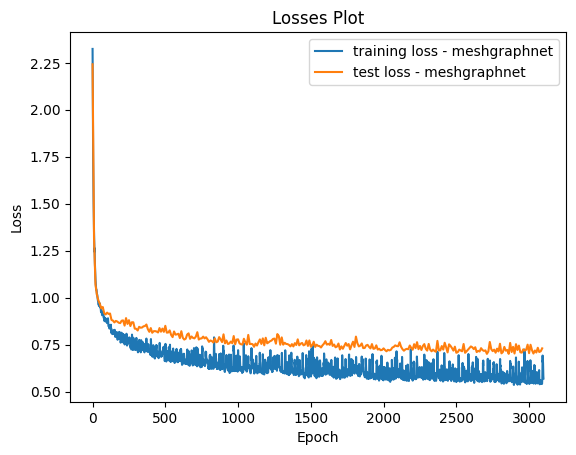

In [ ]:
f = plt.figure()
plt.title('Losses Plot')
plt.plot(losses, label="training loss" + " - " + args.model_type)
x=np.array(list(range(len(test_losses))))*10
plt.plot(x.tolist(),test_losses, label="test loss" + " - " + args.model_type)

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
# load model.
args.device = torch.device('cpu') # animation function cannot work with data on GPU
num_node_features = dataset[0].x.shape[1]
num_edge_features = dataset[0].edge_attr.shape[1]
num_classes = 6 # we are predicting 6 stresses
PATH = os.path.join( root_dir, 'pretrained_model.pt')
model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(args.device)

model.load_state_dict(torch.load(PATH, map_location=args.device))

<All keys matched successfully>

In [ ]:
stats_list

[tensor([ 8.8900e-05, -2.6569e-05,  6.0891e-02,  3.2143e-01,  6.7857e-01]),
 tensor([0.1186, 0.1186, 0.0413, 0.4670, 0.4670]),
 tensor([ 2.2521e-12, -2.1797e-12,  3.5701e-12,  2.2535e-02]),
 tensor([0.0132, 0.0132, 0.0134, 0.0043]),
 tensor([ 1.9870e+04, -4.1889e+05, -3.9730e+03, -1.6244e+02, -6.8635e+01,
          7.2345e+01]),
 tensor([349035.9062, 459813.0312,  87998.1562, 224187.2500,  25754.0781,
          27320.3223])]

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score

#evaluation functions

def get_R2(gs_data, difference, i):

    numerator=np.linalg.norm(difference[:,i:i+1])**2
    diff=gs_data.stress[:,i:i+1]-torch.mean(gs_data.stress[:,i:i+1])
    denominator=np.linalg.norm(diff)**2
    r2=1-numerator/denominator

    return r2

def get_mises(truth, pred):
    df1 = pd.DataFrame(truth, columns = ['s11','s22','s33', 's12','s23','s13'])
    df1["mises"]=df1.apply(lambda x: (((x['s11']-x['s22'])**2+(x['s22']-x['s33'])**2+(x['s11']-x['s33'])**2+6*(x['s12']**2+x['s23']**2+x['s13']**2))/2)**0.5,axis=1)

    df2 = pd.DataFrame(pred, columns = ['s11','s22','s33', 's12','s23','s13'])
    df2["mises"]=df2.apply(lambda x: (((x['s11']-x['s22'])**2+(x['s22']-x['s33'])**2+(x['s11']-x['s33'])**2+6*(x['s12']**2+x['s23']**2+x['s13']**2))/2)**0.5,axis=1)

    return r2_score(df1['mises'].to_numpy(), df2['mises'].to_numpy()), df1['mises'].to_numpy(),  df2['mises'].to_numpy()


def rae(actual, predicted):
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [ ]:
model.eval()
device = args.device
viz_data = {}
gs_data = {}
eval_data = {}

#load your processed dataset
dataset_full_timesteps = torch.load(root_dir+"3D_data_full_example.pt")

dataset = dataset_full_timesteps[:(args.train_size+args.test_size)]

torch.manual_seed(seedss)  #Torch
random.seed(seedss)        #Python
np.random.seed(seedss)
random.shuffle(dataset)


loader=dataset

viz_data_loader = copy.deepcopy(loader)
gs_data_loader = copy.deepcopy(loader)
eval_data_loader = copy.deepcopy(loader)

[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

N=0
R2list_s11=[]
R2list_s22=[]
R2list_s33=[]
R2list_s12=[]
R2list_s13=[]
R2list_s23=[]
mises_list=[]

Error_list_s11=[]
Error_list_s22=[]
Error_list_s33=[]
Error_list_s12=[]
Error_list_s13=[]
Error_list_s23=[]
Error_mises_list=[]


for data, viz_data, gs_data, eval_data in zip(loader, viz_data_loader,gs_data_loader, eval_data_loader):

    data=data.to(args.device)
    viz_data = data.to(args.device)
    with torch.no_grad():
        prediction = model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
        prediction_unnormalize= unnormalize(prediction,mean_vec_y,std_vec_y)

        difference=prediction_unnormalize-gs_data.stress


    if N>=args.train_size:


        s11=get_R2(gs_data, difference, 0)
        s22=get_R2(gs_data, difference, 1)
        s33=get_R2(gs_data, difference, 2)
        s12=get_R2(gs_data, difference, 3)
        s13=get_R2(gs_data, difference, 4)
        s23=get_R2(gs_data, difference, 5)
        mises, mises_aaa , mises_bbb =get_mises(gs_data.stress, prediction_unnormalize)

        error_s11=rae(gs_data.stress[:,0:1].numpy(), prediction_unnormalize[:,0:1].numpy())
        error_s22=rae(gs_data.stress[:,1:2].numpy(), prediction_unnormalize[:,1:2].numpy())
        error_s33=rae(gs_data.stress[:,2:3].numpy(), prediction_unnormalize[:,2:3].numpy())
        error_s12=rae(gs_data.stress[:,3:4].numpy(), prediction_unnormalize[:,3:4].numpy())
        error_s13=rae(gs_data.stress[:,4:5].numpy(), prediction_unnormalize[:,4:5].numpy())
        error_s23=rae(gs_data.stress[:,5:6].numpy(), prediction_unnormalize[:,5:6].numpy())
        error_mises=rae(mises_aaa, mises_bbb)

        if s11>0 and s22>0 and s33>0 and s12>0 and s13>0 and s23>0:

            R2list_s11.append(s11)
            R2list_s22.append(s22)
            R2list_s33.append(s33)
            R2list_s12.append(s12)
            R2list_s13.append(s13)
            R2list_s23.append(s23)
            mises_list.append(mises)

            Error_list_s11.append(error_s11)
            Error_list_s22.append(error_s22)
            Error_list_s33.append(error_s33)
            Error_list_s12.append(error_s12)
            Error_list_s13.append(error_s13)
            Error_list_s23.append(error_s23)
            Error_mises_list.append(error_mises)


        else:
            print("error:",N,s11,s22,s33,s12,s13,s23, mises )


    N=N+1


aa1,bb1,cc1,dd1,ee1,ff1 = np.mean(R2list_s11),np.mean(R2list_s22), np.mean(R2list_s33), np.mean(R2list_s12), np.mean(R2list_s13), np.mean(R2list_s23)
aa2,bb2,cc2,dd2,ee2,ff2 = np.std(R2list_s11),np.std(R2list_s22), np.std(R2list_s33), np.std(R2list_s12), np.std(R2list_s13), np.std(R2list_s23)
gg1, gg2=np.mean(mises_list), np.std(mises_list)



aa3,bb3,cc3,dd3,ee3,ff3 = np.mean(Error_list_s11),np.mean(Error_list_s22), np.mean(Error_list_s33), np.mean(Error_list_s12), np.mean(Error_list_s13), np.mean(Error_list_s23)
aa4,bb4,cc4,dd4,ee4,ff4 = np.std(Error_list_s11),np.std(Error_list_s22), np.std(Error_list_s33), np.std(Error_list_s12), np.std(Error_list_s13), np.std(Error_list_s23)
gg3, gg4=np.mean(Error_mises_list), np.std(Error_mises_list)


print("avg_r2:",np.array([aa1,bb1,cc1,dd1,ee1,ff1,gg1]))
print("std_r2:",np.array([aa2,bb2,cc2,dd2,ee2,ff2,gg2]))

print("avg_rae:",np.array([aa3,bb3,cc3,dd3,ee3,ff3,gg3]))
print("std_rae:",np.array([aa4,bb4,cc4,dd4,ee4,ff4,gg4]))

avg_r2: [0.97335957 0.97846686 0.94946337 0.975058   0.85867527 0.81620114
 0.96453899]
std_r2: [0.0108794  0.00982504 0.01033534 0.00758137 0.04121376 0.08252377
 0.01813767]
avg_rae: [0.16159372 0.13887842 0.2291369  0.15597823 0.40917921 0.4244256
 0.18083607]
std_rae: [0.02746981 0.02730125 0.0248681  0.02225685 0.04187931 0.07204643
 0.03890245]


#### visualization

In [ ]:
gs=gs_data_loader
pred=viz_data_loader
evl=eval_data_loader
n=161

import plotly.graph_objects as go

data=gs[n]
print(data.name)

ro_0.216_ri_0.174_w_0.114_sw_0.044_n_3_E_10000000000.0_l_10000.0_rot_0.0


In [ ]:
pos = data.mesh_pos
faces = data.cells2


prediction = model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
prediction_unnormalize= unnormalize(prediction,mean_vec_y,std_vec_y)

diff=data.stress-prediction_unnormalize


a=pos[:, 0].detach().numpy().tolist()
b=pos[:, 1].detach().numpy().tolist()
c=(pos[:, 2].detach().numpy()).tolist()

d=faces[:, 0].detach().numpy().tolist()
e=faces[:, 1].detach().numpy().tolist()
f=faces[:, 2].detach().numpy().tolist()

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=3, horizontal_spacing=0.01,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]])

color="Jet"

#index_=0 #sigma11
#maxx=1E6
#minn=-1E6


#index_=1 #sigma22
#maxx=1E6
#minn=-1E6

index_=3 #sigma12
maxx=1E6
minn=-1E6


# adding surfaces to subplots.
fig.add_trace(
    go.Mesh3d(
        x=c,y=a,z=b,
        colorbar_title='stress',
        cmax=maxx,
        cmin=minn,
        colorscale=color,
        intensity=gs[n].stress[:, index_].detach().numpy().tolist(),
        i=d,j=e,k=f,name='y1',showscale=True),row=1, col=1)

fig.add_trace(
    go.Mesh3d(
        x=c,y=a,z=b,
        colorbar_title='stress',
        cmax=maxx,
        cmin=minn,
        colorscale=color,
        intensity=prediction_unnormalize[:, index_].detach().numpy().tolist(),
        i=d,j=e,k=f,name='y2',showscale=True),row=1, col=2)

fig.add_trace(
    go.Mesh3d(
        x=c,y=a,z=b,
        colorbar_title='stress',
        cmax=maxx,
        cmin=minn,
        colorscale=color,
        intensity=diff[:, index_].detach().numpy().tolist(),
        i=d,j=e,k=f,name='y3',showscale=True),row=1, col=3)

fig.update_scenes(aspectmode='data')
fig.update_scenes(camera_eye_x=2.9)
fig.update_scenes(camera_eye_y=1.47)
fig.update_scenes(camera_eye_z=1.35)
fig.update_scenes(xaxis_showticklabels=False)
fig.update_scenes(yaxis_showticklabels=False)
fig.update_scenes(zaxis_showticklabels=False)

fig.update_layout(height=550, width=1050, title_text="Side By Side Subplots"+str(index_), showlegend=False)
fig.show()

Output hidden; open in https://colab.research.google.com to view.